<a href="https://colab.research.google.com/github/Asiya-Arif/Spotify-Service-Churn/blob/main/Spotify_Service_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the dataset

In [59]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, roc_curve, auc
)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
import joblib
import matplotlib.pyplot as plt
!pip install xgboost
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import xgboost as xgb

In [3]:
df = pd.read_csv('spotify_churn_dataset.csv')

Basic summary

In [16]:
print("Dataset loaded. Shape:", df.shape)

Dataset loaded. Shape: (5000, 14)


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   int64  
 1   gender                 8000 non-null   object 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   object 
 4   subscription_type      8000 non-null   object 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   object 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   int64  
 11  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 750.1+ KB
None


In [5]:
print(df.describe())

          user_id          age  listening_time  songs_played_per_day  \
count  8000.00000  8000.000000     8000.000000           8000.000000   
mean   4000.50000    37.662125      154.068250             50.127250   
std    2309.54541    12.740359       84.015596             28.449762   
min       1.00000    16.000000       10.000000              1.000000   
25%    2000.75000    26.000000       81.000000             25.000000   
50%    4000.50000    38.000000      154.000000             50.000000   
75%    6000.25000    49.000000      227.000000             75.000000   
max    8000.00000    59.000000      299.000000             99.000000   

         skip_rate  ads_listened_per_week  offline_listening   is_churned  
count  8000.000000            8000.000000        8000.000000  8000.000000  
mean      0.300127               6.943875           0.747750     0.258875  
std       0.173594              13.617953           0.434331     0.438044  
min       0.000000               0.000000      

In [18]:
print("Missing values per column:\n", df.isna().sum())

Missing values per column:
 user_id                  0
gender                   0
age                      0
country                  0
subscription_type        0
listening_time           0
songs_played_per_day     0
skip_rate                0
device_type              0
ads_listened_per_week    0
offline_listening        0
is_churned               0
signup_date              0
last_active_date         0
dtype: int64


In [19]:
churn_rate = df["is_churned"].mean()
print(f"\nOverall churn rate: {churn_rate:.3f} ({int(df['is_churned'].sum())} churned out of {len(df)})")


Overall churn rate: 0.331 (1654 churned out of 5000)


Exploratory Analysis & Visualizations

In [7]:
avg_listening = df.groupby('is_churned')['listening_time'].mean()
print(avg_listening)

is_churned
0    154.446787
1    152.984549
Name: listening_time, dtype: float64


In [6]:
churn_rates = df.groupby('subscription_type')['is_churned'].mean()
print(churn_rates)

subscription_type
Family     0.275157
Free       0.249257
Premium    0.250591
Student    0.261868
Name: is_churned, dtype: float64



Churn rate by subscription_type:
 subscription_type
Free       0.515738
Family     0.257202
Student    0.218487
Premium    0.110679
Name: is_churned, dtype: float64


<Figure size 1000x500 with 0 Axes>

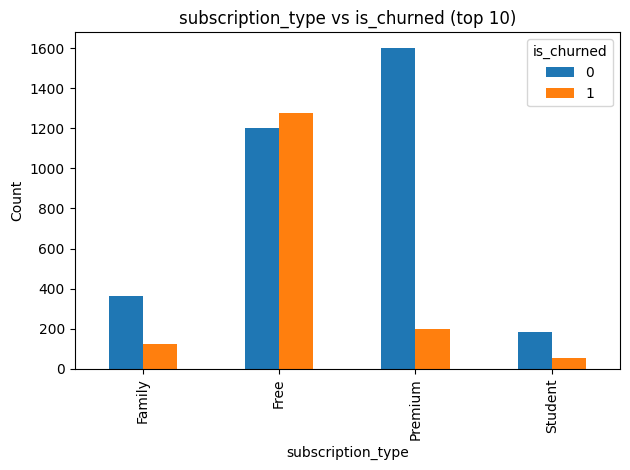

In [21]:
print("\nChurn rate by subscription_type:\n", df.groupby("subscription_type")["is_churned"].mean().sort_values(ascending=False))
bar_chart_counts(df, "subscription_type", target="is_churned", top_k=10)


Churn rate by device_type:
 device_type
Desktop    0.328615
Mobile     0.329639
Web        0.343496
Name: is_churned, dtype: float64


<Figure size 1000x500 with 0 Axes>

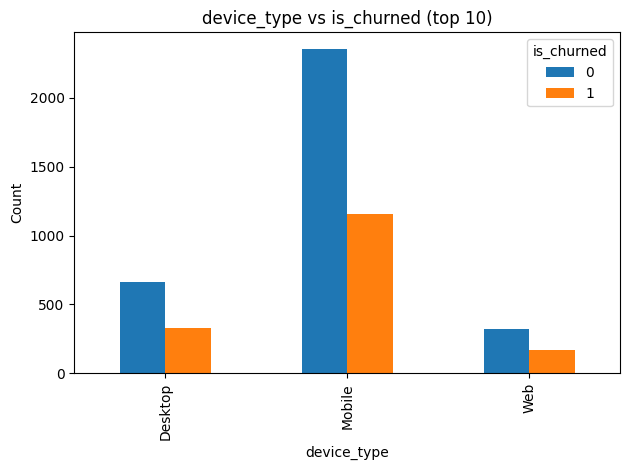

In [22]:
print("\nChurn rate by device_type:\n", df.groupby("device_type")["is_churned"].mean())
bar_chart_counts(df, "device_type", target="is_churned", top_k=10)


Churn rate by gender:
 gender
Female    0.327933
Male      0.336328
Other     0.282051
Name: is_churned, dtype: float64


<Figure size 1000x500 with 0 Axes>

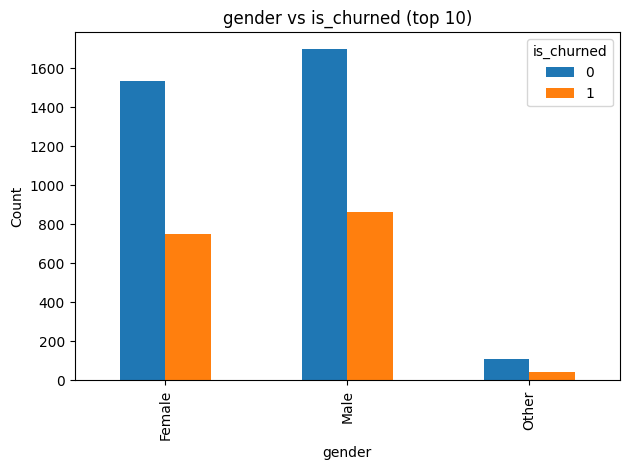

In [23]:
print("\nChurn rate by gender:\n", df.groupby("gender")["is_churned"].mean())
bar_chart_counts(df, "gender", target="is_churned", top_k=10)


Top countries churn rates:
 country
AU    0.353293
BR    0.323353
CA    0.340336
DE    0.346821
FR    0.322394
GB    0.314672
IN    0.357414
NG    0.318182
US    0.317526
ZA    0.312016
Name: is_churned, dtype: float64


<Figure size 1000x500 with 0 Axes>

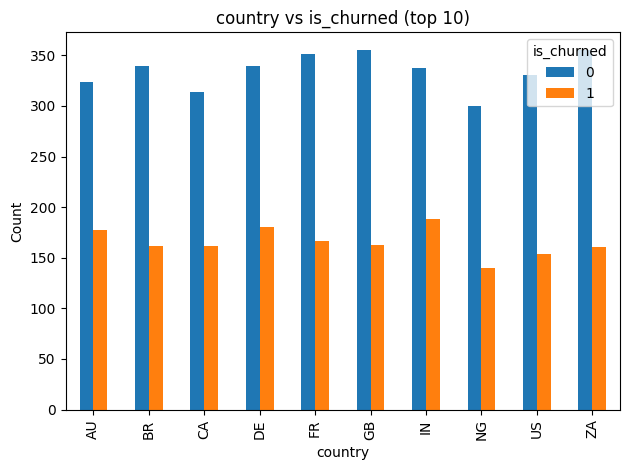

In [24]:
top_countries = df["country"].value_counts().head(10).index.tolist()
print("\nTop countries churn rates:\n", df[df["country"].isin(top_countries)].groupby("country")["is_churned"].mean())
bar_chart_counts(df[df["country"].isin(top_countries)], "country", target="is_churned", top_k=10)

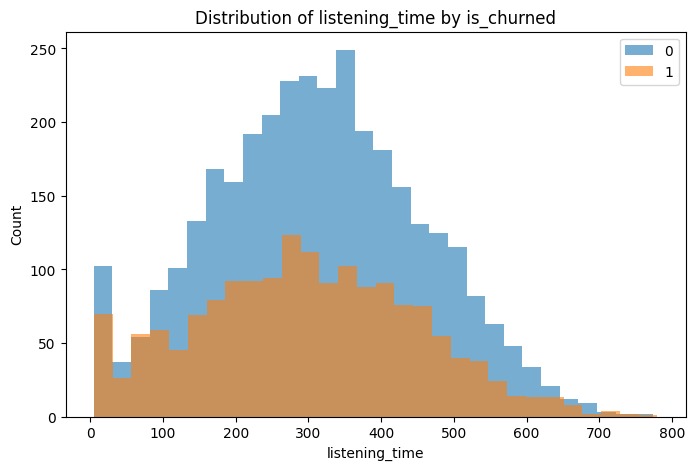

In [26]:
plot_distribution(df, "listening_time", by="is_churned")

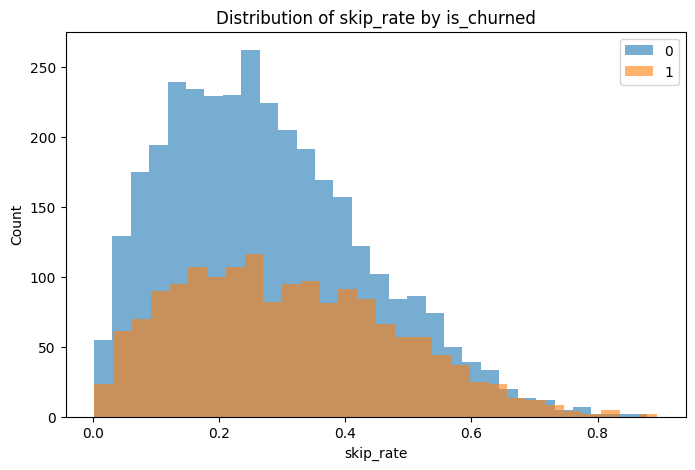

In [27]:
plot_distribution(df, "skip_rate", by="is_churned")

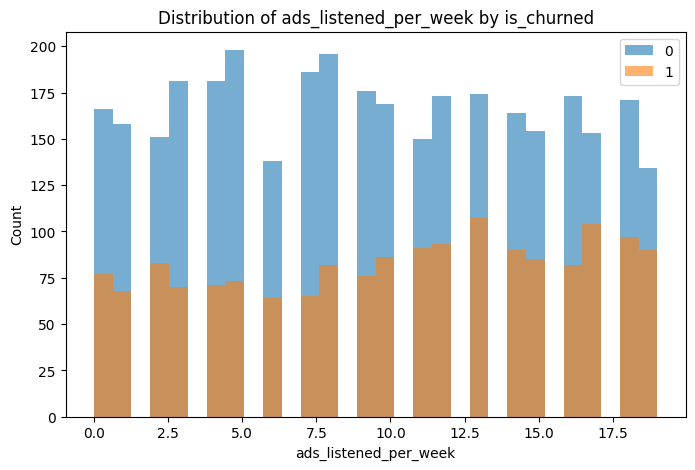

In [28]:
plot_distribution(df, "ads_listened_per_week", by="is_churned")

Feature Engineering

In [34]:
df_feat["sessions_per_month_est"] = (df_feat["listening_time"] / 30).replace(0, np.nan).fillna(0)
df_feat["songs_per_session_est"] = (df_feat["songs_played_per_day"] * 30) / df_feat["sessions_per_month_est"].replace(0,1)
df_feat["skip_rate_bucket"] = pd.cut(df_feat["skip_rate"], bins=[-0.01,0.1,0.25,0.4,1.0], labels=["very_low","low","medium","high"])
df_feat["age_group"] = pd.cut(df_feat["age"], bins=[0,18,25,35,50,100], labels=["<18","18-25","26-35","36-50","50+"])
df_feat["ads_per_listen"] = (df_feat["ads_listened_per_week"] / (df_feat["songs_played_per_day"]*7 + 1)).replace(np.inf,0)
df_feat["free_user_flag"] = (df_feat["subscription_type"]=="Free").astype(int)

show_df(df_feat, "Features after engineering", 5)

--- Features after engineering (first 5 rows) ---
  user_id  gender  age country subscription_type  listening_time  \
0  user_0    Male   33      IN           Premium           514.3   
1  user_1  Female   26      BR           Premium           564.6   
2  user_2    Male   45      BR              Free           349.6   
3  user_3    Male   54      FR              Free           115.9   
4  user_4  Female   29      BR              Free           565.9   

   songs_played_per_day  skip_rate device_type  ads_listened_per_week  \
0                  49.4      0.191      Mobile                     12   
1                  46.0      0.027      Mobile                      9   
2                  39.8      0.088     Desktop                      0   
3                  46.1      0.274      Mobile                     15   
4                  30.8      0.117      Mobile                      2   

   offline_listening  is_churned signup_date last_active_date  \
0                  0           0  202

In [56]:
def feature_engineering(df_feat):
    df_feat["sub_dev_interaction"] = df_feat["subscription_type"].astype(str) + "_" + df_feat["device_type"].astype(str)
    df_feat["country_sub_interaction"] = df_feat["country"].astype(str) + "_" + df_feat["subscription_type"].astype(str)

    if "signup_date" in df_feat.columns and "last_active_date" in df_feat.columns:
        df_feat["signup_date"] = pd.to_datetime(df_feat["signup_date"], errors='coerce')
        df_feat["last_active_date"] = pd.to_datetime(df_feat["last_active_date"], errors='coerce')
        df_feat["tenure_days"] = (df_feat["last_active_date"] - df_feat["signup_date"]).dt.days.clip(lower=0)
        ref_date = df_feat["last_active_date"].max()
        df_feat["recency_days"] = (ref_date - df_feat["last_active_date"]).dt.days.clip(lower=0)
        df_feat["listening_per_day"] = df_feat["listening_time"] / 30.0  # minutes per day
        print("Temporal features: tenure_days, recency_days, listening_per_day created.")
    else:
        print("No signup_date/last_active_date found; skipping temporal features.")

    df_feat["skip_rate_per_song"] = df_feat["skip_rate"]  # placeholder
    return df_feat

Temporal Train-Test Split

In [57]:
def temporal_train_test_split(df_feat, FEATURES, TARGET):
    if "signup_date" in df_feat.columns:
        df_feat = df_feat.sort_values("signup_date")
        cutoff_idx = int(0.7 * len(df_feat))
        train_idx = df_feat.index[:cutoff_idx]
        test_idx = df_feat.index[cutoff_idx:]
        X_time_train = df_feat.loc[train_idx, FEATURES].copy()
        y_time_train = df_feat.loc[train_idx, TARGET].copy()
        X_time_test = df_feat.loc[test_idx, FEATURES].copy()
        y_time_test = df_feat.loc[test_idx, TARGET].copy()
        print("Temporal split done. Train:", X_time_train.shape, "Test:", X_time_test.shape)
        return X_time_train, y_time_train, X_time_test, y_time_test
    else:
        print("No signup_date; temporal split skipped.")
        return None, None, None, None

Prepare Data for Modeling

In [36]:
TARGET = "is_churned"
FEATURES = [
    "gender","age","country","subscription_type","listening_time","songs_played_per_day",
    "skip_rate","device_type","ads_listened_per_week","offline_listening",
    "sessions_per_month_est","songs_per_session_est","skip_rate_bucket","age_group","ads_per_listen","free_user_flag"
]

X = df_feat[FEATURES].copy()
y = df_feat[TARGET].copy()

numeric_feats = ["age","listening_time","songs_played_per_day","skip_rate","ads_listened_per_week","sessions_per_month_est","songs_per_session_est","ads_per_listen"]
categorical_feats = ["gender","country","subscription_type","device_type","skip_rate_bucket","age_group"]

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_feats),
    ("cat", categorical_transformer, categorical_feats),
], remainder="drop")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (4000, 16) Test size: (1000, 16)


Model Training and Evaluation

In [37]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

fitted_models = {}
model_scores = {}

for name, estimator in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("clf", estimator)])
    pipe.fit(X_train, y_train)
    fitted_models[name] = pipe

    preds = pipe.predict(X_test)
    probas = pipe.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    roc = roc_auc_score(y_test, probas)

    model_scores[name] = {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "roc_auc":roc}

    print(f"\n{name} performance on test set:")
    print(pd.Series(model_scores[name]))
    print("\nClassification report:\n", classification_report(y_test, preds, zero_division=0))

scores_df = pd.DataFrame(model_scores).T.sort_values("roc_auc", ascending=False)
show_df(scores_df.reset_index().rename(columns={"index":"model"}), "Model scores (summary)", 10)


LogisticRegression performance on test set:
accuracy     0.708000
precision    0.570909
recall       0.474320
f1           0.518152
roc_auc      0.752212
dtype: float64

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       669
           1       0.57      0.47      0.52       331

    accuracy                           0.71      1000
   macro avg       0.67      0.65      0.65      1000
weighted avg       0.70      0.71      0.70      1000


RandomForest performance on test set:
accuracy     0.719000
precision    0.598425
recall       0.459215
f1           0.519658
roc_auc      0.740351
dtype: float64

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80       669
           1       0.60      0.46      0.52       331

    accuracy                           0.72      1000
   macro avg       0.68      0.65      0.66      1000
weighted avg     

Hyperparameter Tuning

In [60]:
rf_param_dist = {
    "clf__n_estimators": randint(100, 500),
    "clf__max_depth": randint(3, 20),
    "clf__min_samples_split": randint(2, 20),
    "clf__min_samples_leaf": randint(1, 20)
}

xgb_param_dist = {
    "clf__n_estimators": randint(100, 1000),
    "clf__max_depth": randint(3, 12),
    "clf__learning_rate": uniform(0.01, 0.3),
    "clf__subsample": uniform(0.5, 0.5),
    "clf__colsample_bytree": uniform(0.5, 0.5)
}

def run_randomized_search(preprocessor, X_train, y_train):
    pipe_rf = Pipeline([("preprocessor", preprocessor), ("clf", RandomForestClassifier(random_state=42))])
    pipe_xgb = Pipeline([("preprocessor", preprocessor), ("clf", xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])

    rs_rf = RandomizedSearchCV(pipe_rf, rf_param_dist, n_iter=25, scoring="roc_auc", cv=3, verbose=1, n_jobs=-1, random_state=42)
    rs_xgb = RandomizedSearchCV(pipe_xgb, xgb_param_dist, n_iter=25, scoring="roc_auc", cv=3, verbose=1, n_jobs=-1, random_state=42)

    rs_rf.fit(X_train, y_train)
    rs_xgb.fit(X_train, y_train)

    print("Best RF params:", rs_rf.best_params_, "Best ROC AUC:", rs_rf.best_score_)
    print("Best XGB params:", rs_xgb.best_params_, "Best ROC AUC:", rs_xgb.best_score_)

    return rs_rf, rs_xgb

Plot ROC Curves for Models

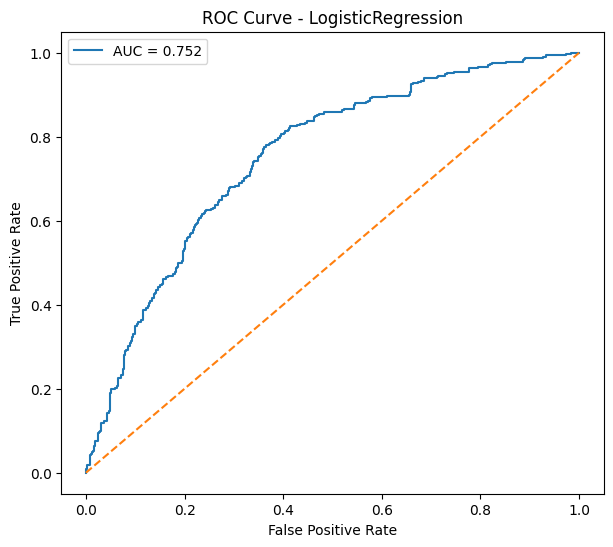

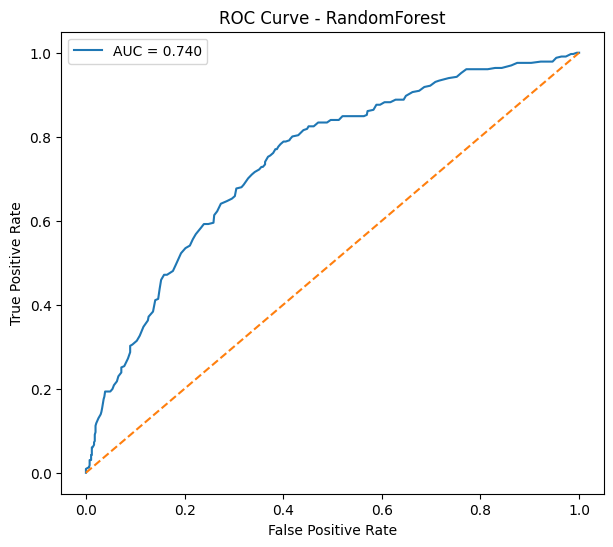

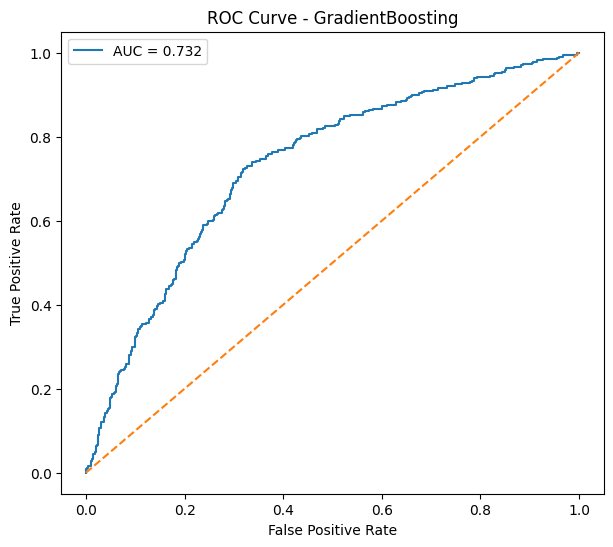

In [38]:
for name, pipe in fitted_models.items():
    probs = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

Feature Importance from Random Forest

In [41]:
num_names = numeric_feats

ohe = fitted_models["RandomForest"].named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_feats))

all_feature_names = num_names + cat_feature_names
print("Total features after preprocessing:", len(all_feature_names))

rf = fitted_models["RandomForest"].named_steps["clf"]
importances = rf.feature_importances_

feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False).head(30)
print("\nTop feature importances (RandomForest):\n", feat_imp)
show_df(feat_imp.reset_index().rename(columns={"index":"feature",0:"importance"}), "Top feature importances", 10)

Total features after preprocessing: 37

Top feature importances (RandomForest):
 subscription_type_Free       0.088173
skip_rate                    0.087061
songs_per_session_est        0.083375
ads_per_listen               0.082119
sessions_per_month_est       0.081114
songs_played_per_day         0.080788
listening_time               0.079113
age                          0.071677
ads_listened_per_week        0.059837
subscription_type_Premium    0.059774
gender_Male                  0.012403
gender_Female                0.012108
device_type_Mobile           0.011731
device_type_Desktop          0.010355
age_group_36-50              0.009703
age_group_50+                0.009566
country_IN                   0.009176
country_FR                   0.009176
country_DE                   0.008926
country_AU                   0.008884
country_ZA                   0.008846
skip_rate_bucket_medium      0.008737
country_GB                   0.008628
age_group_26-35              0.008422
country

KMeans Clustering on Behavioral Features

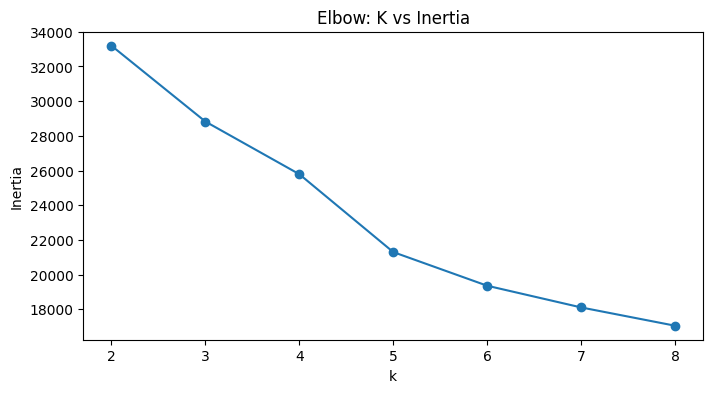

In [42]:
behavioral_feats = ["listening_time","songs_played_per_day","skip_rate","ads_listened_per_week","offline_listening","songs_per_session_est","sessions_per_month_est","ads_per_listen"]
X_beh = df_feat[behavioral_feats].fillna(0)

scaler = StandardScaler()
Xb_scaled = scaler.fit_transform(X_beh)

# Elbow method for k=2..8
inertias = []
ks = range(2,9)
for k_ in ks:
    km_ = KMeans(n_clusters=k_, random_state=42, n_init=10)
    km_.fit(Xb_scaled)
    inertias.append(km_.inertia_)

plt.figure(figsize=(8,4))
plt.plot(list(ks), inertias, marker='o')
plt.title("Elbow: K vs Inertia")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [44]:
k = 4
km = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = km.fit_predict(Xb_scaled)
df_feat["cluster"] = clusters

print("Cluster sizes:\n", df_feat["cluster"].value_counts())

Cluster sizes:
 cluster
1    2528
0    2296
2     106
3      70
Name: count, dtype: int64


Silhouette score for k=4: 0.196

Churn rate by cluster:
 cluster
0    0.310105
1    0.350079
2    0.330189
3    0.314286
Name: is_churned, dtype: float64


<Figure size 1000x500 with 0 Axes>

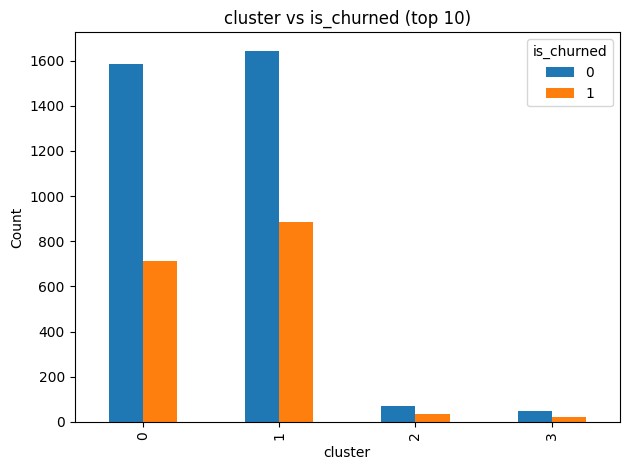

In [45]:
sil = silhouette_score(Xb_scaled, clusters)
print(f"Silhouette score for k={k}: {sil:.3f}")

print("\nChurn rate by cluster:\n", df_feat.groupby("cluster")["is_churned"].mean())
bar_chart_counts(df_feat, "cluster", target="is_churned", top_k=10)

In [46]:
centers = scaler.inverse_transform(km.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=behavioral_feats)
centers_df["cluster"] = centers_df.index
show_df(centers_df, "Cluster centers (approx)", 10)

--- Cluster centers (approx) (first 10 rows) ---
   listening_time  songs_played_per_day  skip_rate  ads_listened_per_week  \
0      434.062745          3.139673e+01   0.277816               9.666231   
1      202.735389          3.050996e+01   0.295365               9.474891   
2        5.391509          3.550660e+01   0.270425               8.773585   
3      323.672857         -1.776357e-14   0.303129              13.014286   

   offline_listening  songs_per_session_est  sessions_per_month_est  \
0           0.481917           6.758963e+01               14.468758   
1           0.514828           2.014836e+02                6.757846   
2           0.528302           6.090236e+03                0.179717   
3           0.485714          -1.136868e-13               10.789095   

   ads_per_listen  cluster  
0        0.095010        0  
1        0.098932        1  
2        0.038631        2  
3       13.014286        3  


Cohort Analysis

In [47]:
if "signup_date" in df_feat.columns and pd.api.types.is_datetime64_any_dtype(df_feat["signup_date"]):
    df_cohort = df_feat.copy()
    df_cohort["signup_month"] = df_cohort["signup_date"].dt.to_period("M").dt.to_timestamp()
    df_cohort["active_month"] = df_cohort["last_active_date"].dt.to_period("M").dt.to_timestamp()

    cohort_data = df_cohort.groupby(["signup_month", "active_month"]).agg(users=("user_id","nunique")).reset_index()
    cohort_data["period_number"] = ((cohort_data["active_month"].dt.year - cohort_data["signup_month"].dt.year) * 12 +
                                   (cohort_data["active_month"].dt.month - cohort_data["signup_month"].dt.month))

    cohort_pivot = cohort_data.pivot_table(index="signup_month", columns="period_number", values="users", aggfunc="sum")
    cohort_size = cohort_pivot.iloc[:,0]
    retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

    print("Cohort retention matrix (first 6 columns):")
    show_df(retention.reset_index(), "Retention matrix", 6)
else:
    print("signup_date and/or last_active_date not available or not datetime dtype in dataset. Skipping cohort analysis sample.")

Cohort retention matrix (first 6 columns):
--- Retention matrix (first 6 rows) ---
period_number signup_month    0      1      2      3      4      5      6  \
0               2020-05-01  1.0  4.000  3.667  2.667  3.667  4.333  4.000   
1               2020-06-01  1.0  2.455  2.455  2.182  2.000  2.455  2.636   
2               2020-07-01  1.0  2.500  2.125  4.375  3.375  3.375  4.250   
3               2020-08-01  1.0  1.750  1.750  1.667  1.333  2.083  1.917   
4               2020-09-01  1.0  2.364  1.818  2.818  2.091  2.636  1.818   
5               2020-10-01  1.0  3.444  3.222  4.556  2.444  3.444  2.333   

period_number      7      8      9     10     11     12     13     14  
0              4.333  3.333  2.667  3.000  5.000  3.000  3.667    NaN  
1              2.273  1.818  3.455  1.727  2.273  1.818  2.545    NaN  
2              3.250  3.375  3.750  3.500  2.875  3.375  2.000    NaN  
3              2.833  1.667  2.000  2.917  2.500  2.833  1.583  0.083  
4              1.

Save Best Model and Artifacts

In [54]:
best_model_name = scores_df.index[0]
best_model = fitted_models[best_model_name]

os.makedirs("models", exist_ok=True)
joblib.dump(best_model, f"models/{best_model_name}.joblib")
joblib.dump(preprocessor, "models/preprocessor.joblib")

print(f"Saved best model: models/{best_model_name}.joblib")

df_feat.head(200).to_csv("models/df_featured_sample.csv", index=False)
print("Saved featured dataset sample to models/df_featured_sample.csv")

Saved best model: models/LogisticRegression.joblib
Saved featured dataset sample to models/df_featured_sample.csv
